In [395]:
from matplotlib import pyplot as plt
import matplotlib.animation
%matplotlib inline
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
from collections import deque
from IPython.display import HTML

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)

frames_cache = None
def animate_agent(
    env,
    model = None,
    pred_fn = lambda x:x,
    state_transformer = lambda x:x,
    max_steps = 10000,
    dfactor = 4,
    ):
    global frames_cache
    obs = env.reset()
    frames = deque()
    frames.append(np.copy(env.render(mode='rgb_array')))
    for i in range(max_steps):
        action = env.action_space.sample()
        obs, _ , done, _ = env.step(action)
        if i % dfactor == 0:
            frames.append(np.copy(env.render(mode='rgb_array')))
        if done:
            break
    frames_cache = frames
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

In [294]:
from skimage.transform import resize

def downscale(obs, new_size=(42,42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)
    else:
        return resize(obs, new_size, anti_aliasing=True)

def convert_obs(obs):
    return torch.from_numpy(downscale(obs)).float()

def transition(state_block, obs):
    new_state = convert_obs(obs)
    rolled_state = torch.roll(state_block, shifts = 1)
    rolled_state[0] = new_state
    return rolled_state

def prepare_initial_state(state,N=3):
    return torch.cat([convert_obs(state).unsqueeze(0)] * N)

In [295]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

from ml_tools.notebook import npi_tqdm
from ml_tools.rl.replay import ExperienceReplayMemory

In [296]:
# Things to try
# Use Prioritized Experience Replay
# Share weights between encoder and q network.
# Use a random projection instead of encoder.

class MarioQNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        self.fc2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        self.fc3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        self.fc4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        
        self.l1 = nn.Linear(288, 30)
        self.l2 = nn.Linear(30, 12)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = x.flatten(start_dim = 1)
        x = F.elu(self.l1(x))
        x = self.l2(x)
        return x
        
model = MarioQNetwork()

In [324]:
def epsilongreedy(epsilon = 0.1):
    def f(x):
        if np.random.rand() > epsilon:
            return np.argmax(x.detach().numpy())
        else:
            return np.random.randint(len(x))
    return f

In [335]:
class ICEncoder(nn.Module):
    # Takes the raw pixel state and develops an encoding.
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        self.fc2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        self.fc3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        self.fc4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 1)
        
    def forward(self, x):
        F.normalize(x)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        # 288 dim
        x = x.flatten(start_dim = 1)
        return x

class ICInverse(nn.Module):
    # Takes 2 encoded states and produces the action that transitions
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(576, 256)
        self.l2 = nn.Linear(256, 12)
    
    def forward(self, enc1, enc2):
        x  = torch.cat((enc1, enc2), dim = 1)
        x = F.elu(self.l1(x))
        x = self.l2(x)
        x = F.softmax(x, dim = 1)
        return x

class ICForward(nn.Module):
    # Takes 12 actions + encoded state and tries to reproduce next enc.
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(300, 256)
        self.l2 = nn.Linear(256, 288)
    
    def forward(self, enc, action):
        n_samples = action.shape[0]
        action_ = torch.zeros(n_samples, 12)
        indices = torch.stack((torch.arange(n_samples), action.squeeze()), dim = 0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat((enc, action_), dim = 1)
        x = F.elu(self.l1(x))
        x = self.l2(x)
        return x

class IntrinsicCuriosityUnit(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_model = ICEncoder()
        self.inverse_model = ICInverse()
        self.forward_model = ICForward()
        
        self.forward_loss_fn = nn.MSELoss(reduction = 'none')
        self.inverse_loss_fn = nn.CrossEntropyLoss(reduction = 'none')
    
    def forward(self, state1, state2, action, forward_scale = 1., inverse_scale = 1e-4):
        enc1 = self.encoder_model(state1)
        enc2 = self.encoder_model(state2)
        action_pred = self.inverse_model(enc1, enc2)
        enc2_pred = self.forward_model(enc1.detach(), action.detach())
        
        floss = self.forward_loss_fn(enc2_pred, enc2.detach())
        iloss = self.inverse_loss_fn(action_pred, action.squeeze())
        forward_err = forward_scale * floss.sum(dim = 1)
        inverse_err = inverse_scale * iloss
        return forward_err, inverse_err
        
        

In [418]:
def minibatch_train(
    erm,
    qnet,
    icm,
    use_extrinsic = True,
    gamma = 0.95,
    eta = 1.,
    batch_size = 50):
    replay_sample = erm.sample(batch_size)
    s1b = replay_sample['state1']
    s2b = replay_sample['state2']
    ab = replay_sample['actions']
    rb = replay_sample['rewards']
    forward_err, inverse_err = icm(s1b, s2b, ab)
    
    qvals1 = qnet(s1b)
    
    with torch.no_grad():
        qvals2 = qnet(s1b)
    
    intrinsic_reward = ( 1/ eta) * forward_err
    
    if use_extrinsic:
        intrinsic_reward += rb
    
    target = intrinsic_reward + gamma * torch.max(qvals2, axis = 1).values

    pred_vals = qvals1[torch.stack((torch.arange(len(ab)), ab.squeeze())).tolist()]
    qnet_err = q_loss(pred_vals, target.detach())
    return qnet_err, forward_err, inverse_err

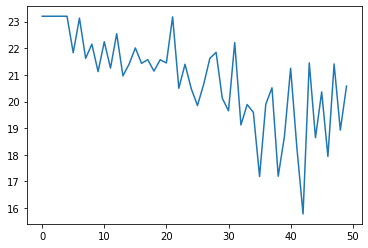

KeyboardInterrupt: 

In [425]:
gamma = 0.95
lr = 0.001
loss_beta = 0.2
loss_lambda = 0.1

epochs = 1000
max_iter = 10000
batch_size = 200

qnet = MarioQNetwork()
icm = IntrinsicCuriosityUnit()
policy = epsilongreedy(0.1)
q_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr = lr)
erm = ExperienceReplayMemory()
losses = []


def loss_fn(q_loss, forward_loss, inverse_loss):
    loss_ = (1 - loss_beta) * inverse_loss
    loss_ += loss_beta * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + loss_lambda * q_loss
    return loss

def plot_fn():
    plt.plot(losses)

last_xpos = 0

obs = env.reset()
state1 = prepare_initial_state(obs)
for epoch in npi_tqdm(range(epochs), plot_fn):
    state1_b = state1.unsqueeze(dim = 0)
    qvals1 = qnet(state1_b)
    action = policy(qvalues)
    obs, reward_, done, info = env.step(action)
    state2 = transition(state1, obs)
    state2_b = state2.unsqueeze(dim = 0)
    xpos = info['x_pos']
    reward = xpos
    if xpos > last_xpos:
        last_xpos = xpos
    erm.add(state1_b, action, reward, state2_b, done)        

    if len(erm) > batch_size:
        qnet_err, forward_err, inverse_err = \
            minibatch_train(erm, qnet, icm, gamma = gamma, batch_size = batch_size)
        loss = loss_fn(qnet_err, forward_err, inverse_err)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if done:
        obs = env.reset()
        state1 = prepare_initial_state(obs)
    state1 = state2

In [422]:
def animate_agent_model(
    env,
    model = None,
    max_steps = 1000,
    dfactor = 4,
    ):
    global frames_cache
    obs = env.reset()
    state1 = prepare_initial_state(obs)
    frames = deque()
    frames.append(np.copy(env.render(mode='rgb_array')))
    for i in range(max_steps):
        state1_b = state1.unsqueeze(dim = 0)
        qvals1 = model(state1_b)
        action = policy(qvalues)
        obs, _ , done, _ = env.step(action)
        state1 = transition(state1, obs)
        if i % dfactor == 0:
            frames.append(np.copy(env.render(mode='rgb_array')))
        if done:
            break
    frames_cache = frames
    return animate_frames(frames)

In [423]:
animate_agent_model(env, qnet)


KeyboardInterrupt

